# 2016 US General Election

---

---

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import DescrStatsW

import us

import sys

import os
path = os.getcwd()
path = path[:path.find('us_election2020')] + 'us_election2020'

sys.path.append(path + '\\src\\data')
import make_dataset

In [2]:
polls2016 = pd.read_csv(path + '\\data\\raw\\president_polls2016.csv', 
                        parse_dates=['startdate', 'enddate', 'createddate', 
                                     'timestamp', 'forecastdate'], index_col=['startdate'])

In [3]:
polls2016['state'] = polls2016['state'].replace({'U.S.':'National', 
                            'Maine CD-1':'Maine', 'Maine CD-2':'Maine', 
                            'Nebraska CD-1':'Nebraska', 'Nebraska CD-2':'Nebraska', 'Nebraska CD-3':'Nebraska'})

In [4]:
polls2016 = polls2016.drop(['adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin', 
                            'matchup', 'timestamp', 'cycle', 'branch', 'forecastdate', 'grade', 'poll_wt', 
                            'multiversions'], axis='columns')

In [5]:
polls2016 = polls2016.reset_index().rename({'startdate':'start_date', 'enddate':'end_date', 'createddate':'created_date', 
                  'samplesize':'sample_size', 
                  'rawpoll_clinton':'Clinton', 'rawpoll_trump':'Trump', 
                  'rawpoll_johnson':'Johnson', 'rawpoll_mcmullin':'McMullin'}, axis='columns')

In [6]:
population_weight = {'a':0.7, 'v':0.8, 'rv':0.9, 'lv':1.}
polls2016['population_weight'] = polls2016['population'].replace(population_weight)

In [7]:
polls2016.columns

Index(['start_date', 'type', 'state', 'end_date', 'pollster', 'sample_size',
       'population', 'Clinton', 'Trump', 'Johnson', 'McMullin', 'url',
       'poll_id', 'question_id', 'created_date', 'population_weight'],
      dtype='object')

In [8]:
polls2016['diff'] = polls2016['Clinton'] - polls2016['Trump']
polls2016['weight'] = polls2016['sample_size']*polls2016['population_weight']

In [9]:
polls2016['pollster_id'] = pd.util.hash_array(polls2016['pollster'])

In [10]:
dropp_pollsters = ['Google Consumer Surveys', 'SurveyMonkey', 'RAND (American Life Panel)', 
                   'Data Targeting', 'CVOTER International', 
                   'RABA Research', 'Rasmussen Reports/Pulse Opinion Research', 'Saint Leo University', 
                   'Robert Morris University', 'SurveyUSA', 
                   'TargetPoint''icitizen', 
                   'Insights West', 'icitizen', 'Normington', 'TargetPoint', 'McLaughlin & Associates', 
                   'American Research Group', 'Public Religion Research Institute', 'The Times-Picayune/Lucid', 'Centre College']
polls2016 = polls2016[~polls2016['pollster'].isin(dropp_pollsters)]

polls2016 = polls2016[(polls2016['state']=='National')&(polls2016['sample_size']>500)]

In [11]:
polls2016[(polls2016['state']=='National')].pollster.unique()

array(['ABC News/Washington Post', 'Ipsos', 'YouGov', 'Gravis Marketing',
       'Fox News/Anderson Robbins Research/Shaw & Company Research',
       'CBS News/New York Times', 'NBC News/Wall Street Journal',
       'IBD/TIPP', 'Selzer & Company', 'Angus Reid Global',
       'Monmouth University', 'Marist College', 'USC Dornsife/LA Times',
       'RKM Research and Communications, Inc.', 'Morning Consult',
       'Pew Research Center', 'GfK Group', 'Suffolk University',
       'Quinnipiac University', 'Public Policy Polling',
       'CNN/Opinion Research Corp.',
       'Greenberg Quinlan Rosner (Democracy Corps)',
       'Princeton Survey Research Associates International',
       'George Washington University (Battleground)', 'Edison Research',
       'Echelon Insights', 'Emerson College', 'Utah Valley University',
       'Zogby Interactive/JZ Analytics', 'Normington, Petts & Associates',
       'Penn Schoen Berland', 'University of Delaware',
       'National Journal', 'Schoen Consult

In [12]:
polls2016 = polls2016.sort_values(['start_date', 'end_date']).set_index('start_date')
polls2016

,type,state,end_date,pollster,sample_size,population,Clinton,Trump,Johnson,McMullin,url,poll_id,question_id,created_date,population_weight,diff,weight,pollster_id
start_date,,,,,,,,,,,,,,,,,,
2015-11-13,polls-plus,National,2015-11-16,Morning Consult,2001.0,rv,44.0,43.0,NaN,NaN,http://morningconsult.com/wp-content/uploads/2...,35379,47244,2015-11-17,0.9,1.0,1800.9,9104766023743465720
2015-11-13,now-cast,National,2015-11-16,Morning Consult,2001.0,rv,44.0,43.0,NaN,NaN,http://morningconsult.com/wp-content/uploads/2...,35379,47244,2015-11-17,0.9,1.0,1800.9,9104766023743465720
2015-11-13,polls-only,National,2015-11-16,Morning Consult,2001.0,rv,44.0,43.0,NaN,NaN,http://morningconsult.com/wp-content/uploads/2...,35379,47244,2015-11-17,0.9,1.0,1800.9,9104766023743465720
2015-11-15,polls-plus,National,2015-12-02,Marist College,2360.0,rv,52.0,41.0,NaN,NaN,http://www.nbcnews.com/meet-the-press/clinton-...,35415,47408,2015-12-07,0.9,11.0,2124.0,7463554682906178616
2015-11-15,now-cast,National,2015-12-02,Marist College,2360.0,rv,52.0,41.0,NaN,NaN,http://www.nbcnews.com/meet-the-press/clinton-...,35415,47408,2015-12-07,0.9,11.0,2124.0,7463554682906178616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-04,polls-plus,National,2016-11-07,IBD/TIPP,1107.0,lv,41.2,42.7,7.1,NaN,http://www.investors.com/politics/ibd-tipp-pre...,48916,76611,2016-11-08,1.0,-1.5,1107.0,9176589997386146786
2016-11-04,now-cast,National,2016-11-07,YouGov,3677.0,lv,45.0,41.0,5.0,NaN,https://d25d2506sfb94s.cloudfront.net/cumulus_...,48687,76262,2016-11-07,1.0,4.0,3677.0,2125552566652732525
2016-11-04,now-cast,National,2016-11-07,IBD/TIPP,1107.0,lv,41.2,42.7,7.1,NaN,http://www.investors.com/politics/ibd-tipp-pre...,48916,76611,2016-11-08,1.0,-1.5,1107.0,9176589997386146786


---

In [30]:
def get_state_statsSmooth2016_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]
    cols_wgt = ['weight_'+ c for c in candidates]

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]

    start = str(df.index.min().date())
    end = str(df.index.max().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
    
    df['weight'] = (df[['weight']])**(1/4)
    
    day0 = str(index_stats_df[0].date())
    atK_df = df.loc[:day0].tail(k)
    atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
    atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
    atK_df['weight'] = atK_df['weight']/(atK_df['times'])
    
    state_stats_df.loc[day0, cols_avg] = atK_df[candidates].values[0]
    state_stats_df.loc[day0, cols_std] = np.nan
    
    for day in index_stats_df[1:]:
        day = str(day.date())
        atK_df = df.loc[:day].tail(k)
        
        atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
        atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
        atK_df['weight'] = atK_df['weight']/(atK_df['times'])
            
        for col in cols_wgt:
            atK_df[col] = atK_df['weight']
            
        r_dispersion = ((np.abs((atK_df[candidates] - state_stats_df[cols_avg].dropna().iloc[-1].values)) + 1).values**(2))
        atK_df[cols_wgt] /= r_dispersion
    
        for i in range(3):
            weighted_stats = DescrStatsW(atK_df[candidates[i]], weights=atK_df[cols_wgt[i]], ddof=0)
            state_stats_df.loc[day, [cols_avg[i]]] = weighted_stats.mean.reshape(-1,)
            state_stats_df.loc[day, [cols_std[i]]] = weighted_stats.std.reshape(-1,)

    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    #if state == 'National':
     #   round(state_stats_df, 4).to_csv(path+'\\data\\processed\\National_stats_at'+str(k)+'.csv')
    return round(state_stats_df, 4)

In [40]:
def get_state_statsSmooth2016_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]
    cols_wgt = ['weight_'+ c for c in candidates]

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]

    start = str(df.index.min().date())
    end = str(df.index.max().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
    
    df['weight'] = (df[['weight']])**(1/4)
    
    day0 = str(index_stats_df[0].date())
    atK_df = df.loc[:day0].tail(k)
    atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
    atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
    atK_df['weight'] = atK_df['weight']/(atK_df['times'])
    
    state_stats_df.loc[day0, cols_avg] = atK_df[candidates].values[0]
    state_stats_df.loc[day0, cols_std] = np.nan
    
    for day in index_stats_df[1:]:
        day = str(day.date())
        atK_df = df.loc[:day].tail(k)
        
        atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
        atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
        atK_df['weight'] = atK_df['weight']/(atK_df['times'])
            
        for col in cols_wgt:
            atK_df[col] = atK_df['weight']
            
        r_dispersion = ((np.abs((atK_df[candidates] - state_stats_df[cols_avg].dropna().iloc[-1].values)) + 1).values**(2))
        atK_df[cols_wgt] /= r_dispersion
        
        atK_df['weight'] = np.mean(atK_df[cols_wgt], axis='columns')
    
        for i in range(3):
            weighted_stats = DescrStatsW(atK_df[candidates[i]], weights=atK_df['weight'], ddof=0)
            state_stats_df.loc[day, [cols_avg[i]]] = weighted_stats.mean.reshape(-1,)
            state_stats_df.loc[day, [cols_std[i]]] = weighted_stats.std.reshape(-1,)

    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    #if state == 'National':
     #   round(state_stats_df, 4).to_csv(path+'\\data\\processed\\National_stats_at'+str(k)+'.csv')
    return round(state_stats_df, 4)

In [41]:
national_statsSmooth_k = get_state_statsSmooth2016_atK(polls2016, candidates=['Clinton', 'Trump'], state='National', k=8)
national_statsSmooth_2k = get_state_statsSmooth2016_atK(polls2016, candidates=['Clinton', 'Trump'], state='National', k=16)

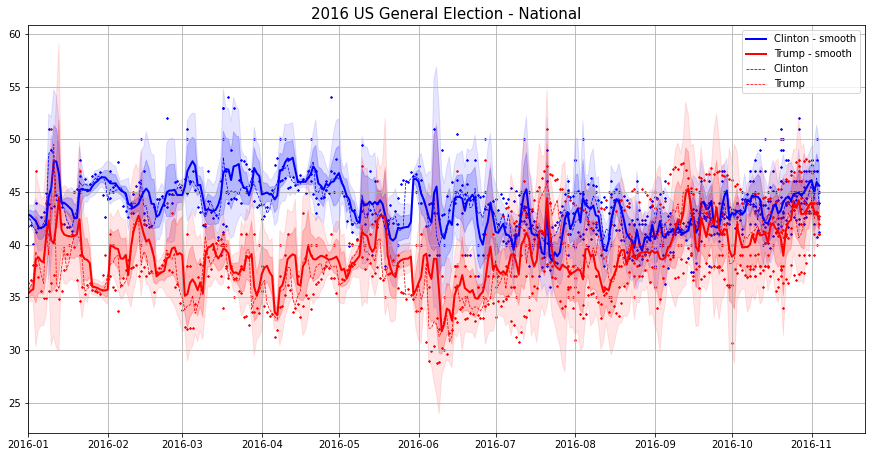

In [42]:
plt.figure(figsize=(15, 7.5))

plt.plot(national_statsSmooth_2k[['Clinton_avg']], lw=2., label='Clinton - smooth', color='blue')
plt.plot(national_statsSmooth_2k[['Trump_avg']], lw=2., label='Trump - smooth', color='red')

plt.plot(national_statsSmooth_k[['Clinton_avg']], lw=0.75, ls='--', label='Clinton', color='blue')
plt.plot(national_statsSmooth_k[['Trump_avg']], lw=0.75, ls='--', label='Trump', color='red')

candidates_color = {'Clinton':'blue', 'Trump':'red'}
for candidate in ['Clinton', 'Trump']:
    plt.scatter(polls2016.loc[polls2016['state']=='National'].index, 
                polls2016.loc[polls2016['state']=='National'][candidate], color=candidates_color[candidate], s=1.)
    plt.fill_between(national_statsSmooth_2k[candidate+'_avg'].index,
                     national_statsSmooth_2k[candidate+'_avg']+2*national_statsSmooth_2k[candidate+'_std'],
                     national_statsSmooth_2k[candidate+'_avg']-2*national_statsSmooth_2k[candidate+'_std'],
                     alpha=0.1, color=candidates_color[candidate])
    plt.fill_between(national_statsSmooth_2k[candidate+'_avg'].index,
                     national_statsSmooth_2k[candidate+'_avg']+national_statsSmooth_2k[candidate+'_std'],
                     national_statsSmooth_2k[candidate+'_avg']-national_statsSmooth_2k[candidate+'_std'],
                     alpha=0.2, color=candidates_color[candidate])

plt.title('2016 US General Election - National', fontsize=15)
plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2016-01-01'))

plt.show()

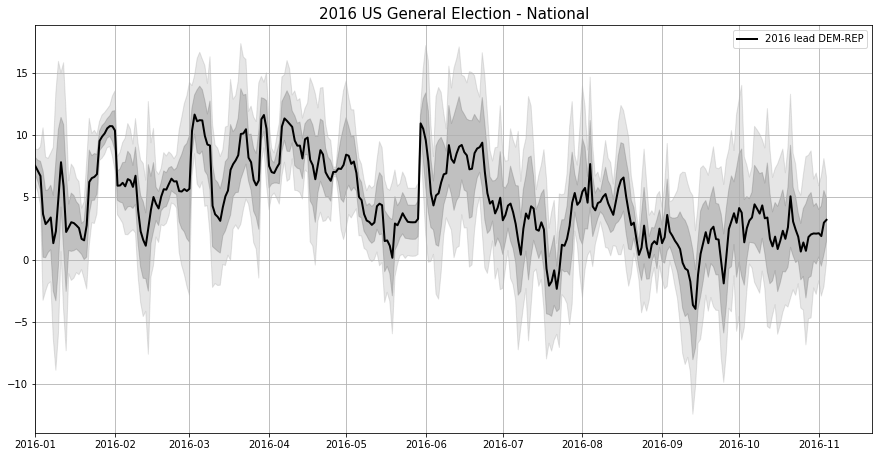

In [43]:
plt.figure(figsize=(15, 7.5))

plt.plot(national_statsSmooth_2k['diff_avg'], lw=2., label='2016 lead DEM-REP', color='black')


for candidate in ['Biden', 'Trump']:
    plt.fill_between(national_statsSmooth_2k['diff_avg'].index,
                     national_statsSmooth_2k['diff_avg']+2*national_statsSmooth_2k['diff_std'],
                     national_statsSmooth_2k['diff_avg']-2*national_statsSmooth_2k['diff_std'],
                     alpha=0.1, color='gray')
    plt.fill_between(national_statsSmooth_2k['diff_avg'].index,
                     national_statsSmooth_2k['diff_avg']+national_statsSmooth_2k['diff_std'],
                     national_statsSmooth_2k['diff_avg']-national_statsSmooth_2k['diff_std'],
                     alpha=0.2, color='gray')

plt.title('2016 US General Election - National', fontsize=15)
plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2016-01-01'))
plt.show()